# Milestone 2: Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set_theme()

MODULES = [
    "core",
    "io",
    "cc",
    "fnml",
    "star",
]

In [2]:
ROOT = Path("..")
DATA_DIR = Path("data")
TEST_CASES_DIR = Path("test-cases")
METADATA_CSV = Path("metadata.csv")

metadata = None

for module in MODULES:
    module_name = f"rml-{module}"
    module_path = ROOT / DATA_DIR / module_name
    test_cases_path = module_path / TEST_CASES_DIR
    current_metadata = pd.read_csv(test_cases_path / METADATA_CSV)
    current_metadata["module"] = module_name

    # Aggregate
    if metadata is None:
        metadata = current_metadata
    else:
        metadata = pd.concat([metadata, current_metadata])

metadata.head()

,ID,title,description,specification,base_iri,mapping,input_format1,input_format2,input_format3,output_format1,output_format2,output_format3,input1,input2,input3,output1,output2,output3,error,module
0,RMLTC0000-JSON,"""one table, one column, zero rows""","""Tests if an empty table produces an empty RDF...",http://w3id.org/rml/core/,http://example.org/,mapping.ttl,application/json,NaN,NaN,application/n-quads,NaN,NaN,student.json,NaN,NaN,output.nq,NaN,NaN,False,rml-core
1,RMLTC0001a-JSON,"""One column mapping, subject URI generation by...","""Tests: (1) one column mapping; (2) subject UR...",http://w3id.org/rml/core/,http://example.org/,mapping.ttl,application/json,NaN,NaN,application/n-quads,NaN,NaN,student.json,NaN,NaN,output.nq,NaN,NaN,False,rml-core
2,RMLTC0001b-JSON,"""One column mapping, generation of a BlankNode...","""Tests: (1) one column mapping; (2) generation...",http://w3id.org/rml/core/,http://example.org/,mapping.ttl,application/json,NaN,NaN,application/n-quads,NaN,NaN,student.json,NaN,NaN,output.nq,NaN,NaN,False,rml-core
3,RMLTC0002a-JSON,"""Two columns mapping, generation of a subject ...","""Tests: (1) two column mapping, no primary key...",http://w3id.org/rml/core/,http://example.org/,mapping.ttl,application/json,NaN,NaN,application/n-quads,NaN,NaN,student.json,NaN,NaN,output.nq,NaN,NaN,False,rml-core
4,RMLTC0002b-JSON,"""Two columns mapping, generation of a BlankNod...","""Tests: (1) two column mapping, no primary key...",http://w3id.org/rml/core/,http://example.org/,mapping.ttl,application/json,NaN,NaN,application/n-quads,NaN,NaN,student.json,NaN,NaN,output.nq,NaN,NaN,False,rml-core


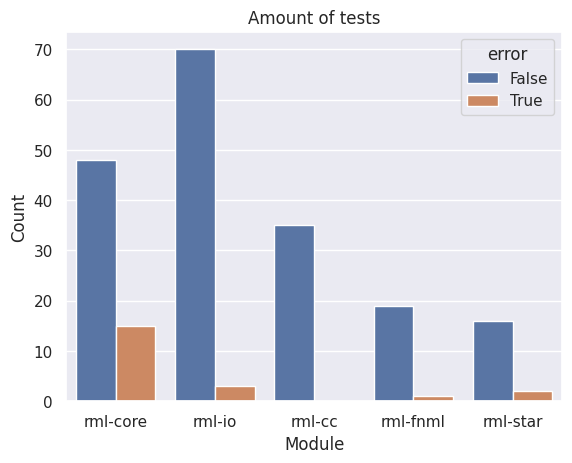

In [3]:
plt.xlabel("Module")
plt.ylabel("Count")
plt.title("Amount of tests")
sns.countplot(metadata, x="module", hue="error");

In [4]:
from typing import Literal

def plot_io(label: Literal["input"] | Literal["output"]):
    fig, axes = plt.subplots(2, 3, figsize=(10,7))
    
    for ax, (module_name, module_data) in zip(axes.flat, (metadata.groupby("module"))):
        input_formats = pd.concat([
            module_data[f"{label}_format{i}"]
            for i in range(1, 3)
        ]).dropna().map(lambda x: x.removeprefix("application/").removeprefix("text/"))
    
        is_single_input_format = input_formats.value_counts().shape[0] > 1
            
        sns.countplot(
            pd.DataFrame(input_formats, columns=["format"]),
            x="format",
            stat="percent",
            ax=ax,
        )
    
        if is_single_input_format:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation_mode="anchor", rotation=30)
    
        ax.set_xlabel("")
        ax.set_title(module_name)
        
    fig.suptitle(f"{label.capitalize()} format for each module")
    plt.delaxes(axes[1, 2])
    plt.tight_layout()


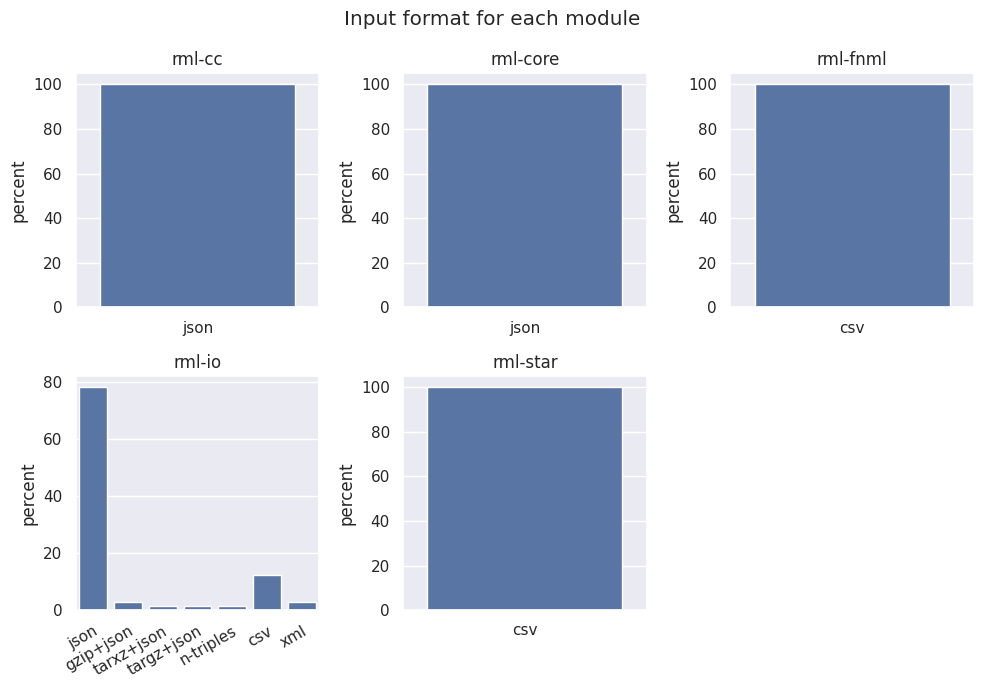

In [5]:
plot_io("input")

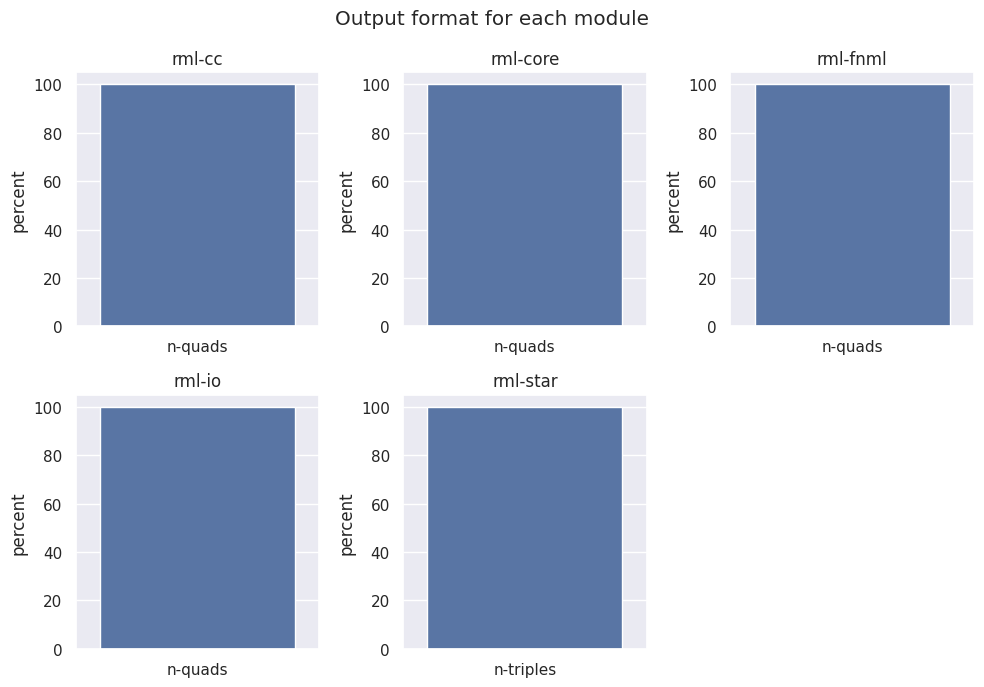

In [6]:
plot_io("output")

In [7]:
import rdflib

metadata_mapping = (
    ROOT
    / DATA_DIR
    / metadata["module"]
    / TEST_CASES_DIR
    / metadata["ID"]
    / metadata["mapping"]
)

metadata["mapping_path"] = metadata_mapping
metadata["graph"] = None
not_error_mask = ~metadata["error"]
metadata.loc[not_error_mask, "graph"] = metadata.loc[not_error_mask, "mapping_path"].map(lambda path: rdflib.Graph().parse(str(path)))

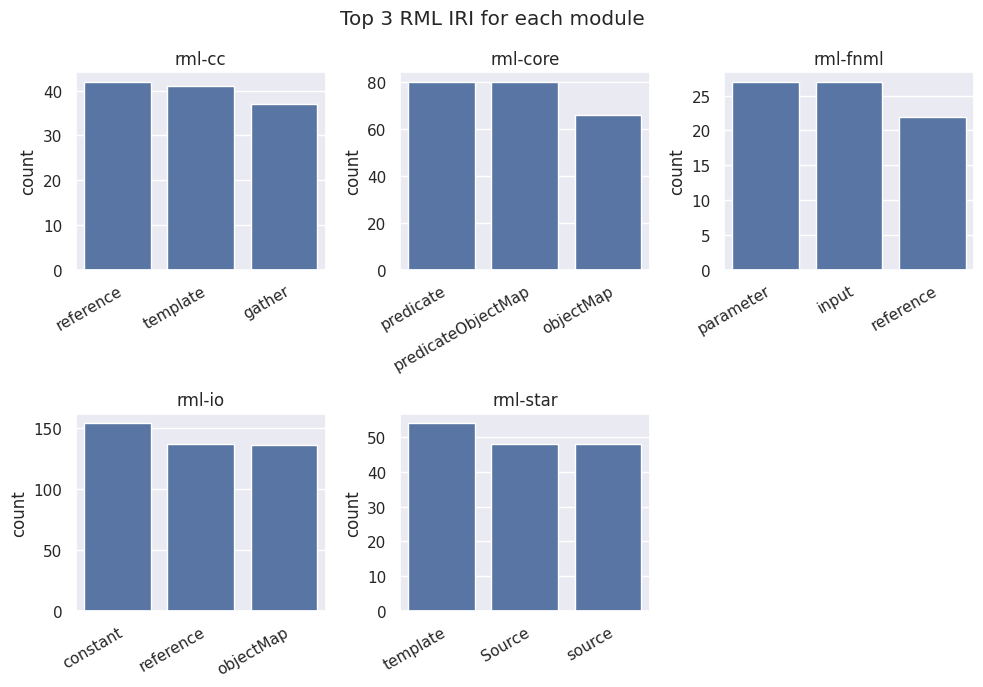

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10,7))

RML = "http://w3id.org/rml/"
N_TOP = 3

def graph_to_rml_IRIs(graph: rdflib.Graph) -> list[str]:
    return [
        iri.removeprefix(RML)
        for triple in graph.triples((None, None, None))
        for iri in triple
        if iri.startswith(RML)
    ]

for ax, (module_name, module_data) in zip(axes.flat, (metadata.groupby("module"))):
    sns.barplot(
        module_data["graph"].dropna().map(graph_to_rml_IRIs).explode().value_counts().iloc[:N_TOP],
        ax=ax,
    )

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation_mode="anchor", rotation=30)
    ax.set_xlabel("")
    ax.set_title(module_name)
    
fig.suptitle(f"Top 3 RML IRI for each module")
plt.delaxes(axes[1, 2])
plt.tight_layout()